In [1]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, Attention, Concatenate, Lambda, LayerNormalization

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

2025-12-14 12:44:49.732730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765716290.132539      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765716290.218141      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df = pd.read_csv("/kaggle/input/trajectory-forecasting-data/BA12072_resampled_1h_features_02.csv", parse_dates=["timestamp"])

In [4]:
df.fillna(0, inplace=True)
df.drop(columns=['heading'], inplace=True)
df.head()

,timestamp,external-temperature,ground-speed,height-above-msl,gls:light-level,x_m,y_m,sin_heading,cos_heading,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month,distance,time_of_day,season
0,2023-11-18 22:00:00,24.9,0.500000,-332.270000,0.000000,3.732663e+06,-2.031658e+06,-0.949425,0.313992,-0.500000,0.866025,-0.587785,-0.809017,-0.5,0.866025,0.000000,night,fall
1,2023-11-18 23:00:00,0.0,0.000000,-1.300000,0.000000,3.732866e+06,-2.031672e+06,0.000000,1.000000,-0.258819,0.965926,-0.587785,-0.809017,-0.5,0.866025,202.879558,night,fall
2,2023-11-19 00:00:00,29.9,0.600000,14.500000,0.000000,3.732859e+06,-2.031723e+06,0.999848,-0.017452,0.000000,1.000000,-0.743145,-0.669131,-0.5,0.866025,51.501405,morning,fall
3,2023-11-19 01:00:00,31.4,0.544444,17.694444,54.777778,3.730107e+06,-2.029516e+06,0.987383,0.158350,0.258819,0.965926,-0.743145,-0.669131,-0.5,0.866025,3526.598258,morning,fall
4,2023-11-19 02:00:00,32.9,0.488889,20.888889,109.555556,3.727356e+06,-2.027311e+06,0.944249,0.329233,0.500000,0.866025,-0.743145,-0.669131,-0.5,0.866025,3526.069804,morning,fall


In [5]:
features = ['external-temperature', 'ground-speed', 'height-above-msl', 'gls:light-level', 'sin_heading', 'cos_heading',
            'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_month', 'cos_month', 'distance', 'time_of_day', 'season']
target = ['x_m', 'y_m']
time_col = 'timestamp'

In [6]:
def create_windowed_dataset(df, features, target, time_col, input_window, forecast_horizon, step=1):
    X, y, y_time = [], [], []
    for i in range(0, len(df) - input_window - forecast_horizon, step):
        X.append(df[features+target].iloc[i:i+input_window].values)
        y.append(df[target].iloc[i+input_window:i+input_window+forecast_horizon].values)
        y_time.append(df[time_col].iloc[i+input_window:i+input_window+forecast_horizon].values)
    return np.array(X), np.array(y), np.array(y_time)

def ade(y_true, y_pred):
    """Average Displacement Error (ADE)"""
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))

def fde(y_true, y_pred):
    """Final Displacement Error (FDE)"""
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true[:, -1, :] - y_pred[:, -1, :]), axis=-1)))

In [7]:
INPUT_WINDOW = 24
FORECAST_HORIZON = 24
NUM_FEATURES = len(features)
NUM_TARGETS = len(target)
NUM_FEATURES_INPUT = NUM_FEATURES + NUM_TARGETS
NUM_TARGETS_OUTPUT = 2

In [8]:
train_start = '2023-11-18'
train_end = '2024-11-30' 

val_start = '2024-12-01'
val_end = '2025-01-31'   

test_start = '2025-02-01'
test_end = '2025-03-31'   

train_df_raw = df[(df['timestamp'] >= train_start) & (df['timestamp'] <= train_end + ' 23:59:59')].copy()
val_df_raw = df[(df['timestamp'] >= val_start) & (df['timestamp'] <= val_end + ' 23:59:59')].copy()
test_df_raw = df[(df['timestamp'] >= test_start) & (df['timestamp'] <= test_end + ' 23:59:59')].copy()

print(f"Kích thước tập Train: {train_df_raw.shape}")
print(f"Ngày bắt đầu Train: {train_df_raw['timestamp'].min()}")
print(f"Ngày kết thúc Train: {train_df_raw['timestamp'].max()}")
print("-" * 30)
print(f"Kích thước tập Val:   {val_df_raw.shape}")
print(f"Ngày bắt đầu Val:   {val_df_raw['timestamp'].min()}")
print(f"Ngày kết thúc Val:   {val_df_raw['timestamp'].max()}")
print("-" * 30)
print(f"Kích thước tập Test:  {test_df_raw.shape}")
print(f"Ngày bắt đầu Test:  {test_df_raw['timestamp'].min()}")
print(f"Ngày kết thúc Test:  {test_df_raw['timestamp'].max()}")

Kích thước tập Train: (7925, 18)
Ngày bắt đầu Train: 2023-11-18 22:00:00
Ngày kết thúc Train: 2024-11-30 23:00:00
------------------------------
Kích thước tập Val:   (1463, 18)
Ngày bắt đầu Val:   2024-12-01 00:00:00
Ngày kết thúc Val:   2025-01-31 23:00:00
------------------------------
Kích thước tập Test:  (1209, 18)
Ngày bắt đầu Test:  2025-02-01 00:00:00
Ngày kết thúc Test:  2025-03-31 11:00:00


In [9]:
features_std = ['external-temperature', 'gls:light-level', 'distance']
features_robust = ['ground-speed', 'height-above-msl']
target_cols = ['x_m', 'y_m']
label = ['time_of_day', 'season']

scaler_std = StandardScaler()
scaler_robust = RobustScaler()
scaler_target = StandardScaler()
label_encoders = {}

scaler_std.fit(train_df_raw[features_std])
scaler_robust.fit(train_df_raw[features_robust])
scaler_target.fit(train_df_raw[target_cols])
for col in label:
    le = LabelEncoder()
    le.fit(train_df_raw[col])
    label_encoders[col] = le

def preprocess_dataframe(df_in, scalers_enc):
    df_out = df_in.copy()
    df_out[features_std] = scalers_enc['std'].transform(df_in[features_std])
    df_out[features_robust] = scalers_enc['robust'].transform(df_in[features_robust])
    df_out[target_cols] = scalers_enc['target'].transform(df_in[target_cols])
    
    for col in label: 
        df_out[col] = scalers_enc['label_encoders'][col].transform(df_in[col]) 
        
    return df_out

scalers_encoders = {
    'std': scaler_std, 
    'robust': scaler_robust, 
    'target': scaler_target, 
    'label_encoders': label_encoders 
}

train_df_scaled = preprocess_dataframe(train_df_raw, scalers_encoders)
val_df_scaled = preprocess_dataframe(val_df_raw, scalers_encoders)
test_df_scaled = preprocess_dataframe(test_df_raw, scalers_encoders)

X_train_3d, y_train_3d, _ = create_windowed_dataset(
    train_df_scaled, features, target, time_col,
    input_window=INPUT_WINDOW, forecast_horizon=FORECAST_HORIZON
)
X_val_3d, y_val_3d, _ = create_windowed_dataset(
    val_df_scaled, features, target, time_col,
    input_window=INPUT_WINDOW, forecast_horizon=FORECAST_HORIZON
)
X_test_3d, y_test_3d, _ = create_windowed_dataset(
    test_df_scaled, features, target, time_col,
    input_window=INPUT_WINDOW, forecast_horizon=FORECAST_HORIZON
)

In [10]:
encoder_input = Input(shape=(INPUT_WINDOW, NUM_FEATURES_INPUT), name='input')

lstm1_out, state_h1, state_c1 = LSTM(128, return_sequences=True, return_state=True, name='lstm1')(encoder_input)
norm1 = LayerNormalization(name='norm1')(lstm1_out)
drop1 = Dropout(0.4, name='drop1')(norm1)

lstm2_out, state_h2, state_c2 = LSTM(128, return_sequences=True, return_state=True, name='lstm2')(drop1)

query = Lambda(lambda x: tf.expand_dims(x, axis=1), name='expand_query')(state_h2)
attention_out = Attention(name='attention')([query, lstm2_out])
context = Lambda(lambda x: tf.squeeze(x, axis=1), name='squeeze_context')(attention_out)

combined = Concatenate(name='concat')([state_h2, context])
norm2 = LayerNormalization(name='norm2')(combined)

dense1 = Dense(128, activation='relu', name='dense1')(norm2)
drop2 = Dropout(0.5, name='drop2')(dense1)
dense2 = Dense(64, activation='relu', name='dense2')(drop2)
drop3 = Dropout(0.4, name='drop3')(dense2)

output = Dense(FORECAST_HORIZON * NUM_TARGETS_OUTPUT, activation='linear', name='output')(drop3)
output_reshaped = Reshape((FORECAST_HORIZON, NUM_TARGETS_OUTPUT), name='reshape')(output)

model_lstm = tf.keras.Model(inputs=encoder_input, outputs=output_reshaped, name='improved_lstm')
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss=Huber(delta=1.0),
    metrics=[ade, fde]
)

model_lstm.summary()

I0000 00:00:1765716321.235366      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "improved_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 24, 17)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm1 (LSTM)        │ [(None, 24, 128), │     74,752 │ input[0][0]       │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm1               │ (None, 24, 128)   │        256 │ lstm1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop1 (Dropout)     │ (None, 24, 128)   │          0 │ norm1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm2 (LSTM)        │ [(None, 24, 128), │    131,584 │ drop1[0][0]       │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_query        │ (None, 1, 128)    │          0 │ lstm2[0][1]       │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 128)    │          0 │ expand_query[0][… │
│ (Attention)         │                   │            │ lstm2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_context     │ (None, 128)       │          0 │ attention[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 256)       │          0 │ lstm2[0][1],      │
│ (Concatenate)       │                   │            │ squeeze_context[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm2               │ (None, 256)       │        512 │ concat[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 128)       │     32,896 │ norm2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop2 (Dropout)     │ (None, 128)       │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 64)        │      8,256 │ drop2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop3 (Dropout)     │ (None, 64)        │          0 │ dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 48)        │      3,120 │ drop3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 2)     │          0 │ output[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 251,376 (981.94 KB)

 Trainable params: 251,376 (981.94 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

start_time = time.time()

In [12]:
history = model_lstm.fit(
    X_train_3d, y_train_3d,
    epochs=150,
    batch_size=128,
    validation_data=(X_val_3d, y_val_3d),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"Huấn luyện hoàn tất trong {time.time() - start_time:.2f} giây.")

Epoch 1/150


I0000 00:00:1765716329.621705      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - ade: 1.2170 - fde: 1.0569 - loss: 0.4140 - val_ade: 0.4005 - val_fde: 0.3885 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 2/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - ade: 0.6148 - fde: 0.5751 - loss: 0.1210 - val_ade: 0.2406 - val_fde: 0.1953 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 3/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - ade: 0.5056 - fde: 0.4845 - loss: 0.0829 - val_ade: 0.0641 - val_fde: 0.0491 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - ade: 0.4587 - fde: 0.4381 - loss: 0.0687 - val_ade: 0.2326 - val_fde: 0.2225 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 5/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - ade: 0.4328 - fde: 0.4157 - loss: 0.0614 - val_ade: 0.1694 - val_fde: 0.1548 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 6/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - ade: 0.3959 - fde: 0.3825 - loss: 0.0521 - val_ade: 0.2192 - val_fde: 0.2235 - val_loss

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Huber: 75523.9844 | MAE: 75524.49m | R²: 0.8024
ADE: 121883.67m | FDE: 116740.37m


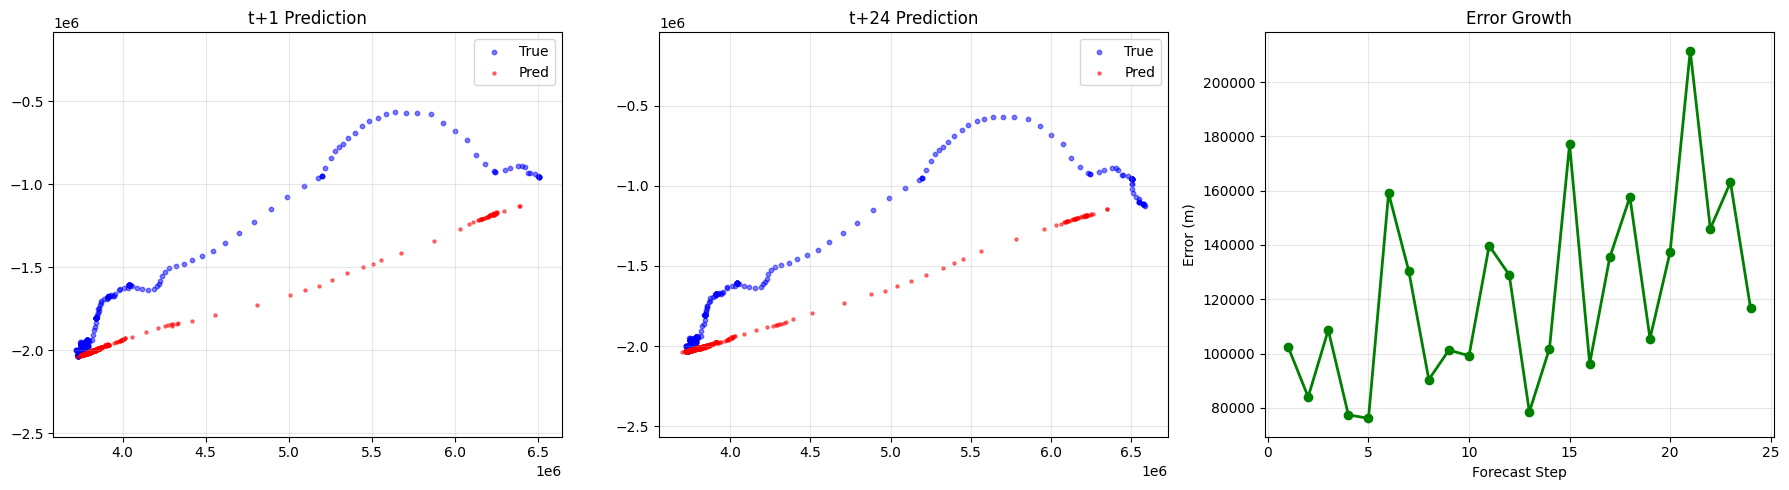

In [13]:
import matplotlib.pyplot as plt

y_pred_scaled = model_lstm.predict(X_test_3d, batch_size=128)

y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, NUM_TARGETS)).reshape(-1, FORECAST_HORIZON, NUM_TARGETS)
y_true = scaler_target.inverse_transform(y_test_3d.reshape(-1, NUM_TARGETS)).reshape(-1, FORECAST_HORIZON, NUM_TARGETS)

huber = Huber()(y_true.reshape(-1, NUM_TARGETS), y_pred.reshape(-1, NUM_TARGETS)).numpy()
mae = mean_absolute_error(y_true.reshape(-1, NUM_TARGETS), y_pred.reshape(-1, NUM_TARGETS))
r2 = r2_score(y_true.reshape(-1, NUM_TARGETS), y_pred.reshape(-1, NUM_TARGETS))
ade_val = ade(y_true, y_pred).numpy()
fde_val = fde(y_true, y_pred).numpy()

print(f"Huber: {huber:.4f} | MAE: {mae:.2f}m | R²: {r2:.4f}")
print(f"ADE: {ade_val:.2f}m | FDE: {fde_val:.2f}m")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_true[:, 0, 0], y_true[:, 0, 1], c='blue', alpha=0.5, s=10, label='True')
axes[0].scatter(y_pred[:, 0, 0], y_pred[:, 0, 1], c='red', alpha=0.5, s=5, label='Pred')
axes[0].set_title('t+1 Prediction')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

axes[1].scatter(y_true[:, -1, 0], y_true[:, -1, 1], c='blue', alpha=0.5, s=10, label='True')
axes[1].scatter(y_pred[:, -1, 0], y_pred[:, -1, 1], c='red', alpha=0.5, s=5, label='Pred')
axes[1].set_title('t+24 Prediction')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

errors = np.sqrt(np.sum((y_true - y_pred)**2, axis=-1)).mean(axis=0)
axes[2].plot(range(1, FORECAST_HORIZON+1), errors, marker='o', linewidth=2, color='green')
axes[2].set_xlabel('Forecast Step')
axes[2].set_ylabel('Error (m)')
axes[2].set_title('Error Growth')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
import joblib

model_lstm.save('best_lstm_model.keras')
joblib.dump(scaler_std, 'scaler_std.joblib')
joblib.dump(scaler_robust, 'scaler_robust.joblib')
joblib.dump(scaler_target, 'scaler_target.joblib')
joblib.dump(label_encoders, 'label_encoders.joblib')

import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)